In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import torch
from torchseis import FaultPipeline, FaultSeg3dPlus
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
def ramp(cmap, blow=0, up=1, alpha_min=0, alpha_max=1):
    """
    Creates a modified colormap from an existing colormap, with adjustable transparency (alpha) levels.
    
    Parameters:
    - cmap: The original colormap to be modified.
    - blow (float, optional): The lower bound of the colormap normalization range. Defaults to 0.
    - up (float, optional): The upper bound of the colormap normalization range. Defaults to 1.
    - alpha_min (float, optional): The minimum alpha (transparency) value to apply. Defaults to 0.
    - alpha_max (float, optional): The maximum alpha (transparency) value to apply. Defaults to 1.
    
    Returns:
    - A new colormap with alpha adjusted from alpha_min to alpha_max within the specified range [blow, up].
    """

    cmap = plt.get_cmap(cmap)
    slope = (alpha_max - alpha_min) / (up - blow)
    N = cmap.N
    arr = cmap(np.arange(N))
    istart = int(blow * N)
    iend = int(up * N)
    arr[:istart, 3] = alpha_min
    arr[iend:, 3] = alpha_max
    arr[istart:iend, 3] = np.arange(iend - istart) / N * slope + alpha_min
    cmap = ListedColormap(arr)
    return cmap

cmap2 = ramp('jet', 0.13, 0.6)

In [4]:
d = np.fromfile('/wzg2/data/gsbcut_h1001x2622x555.dat', np.float32).reshape(555, 2622, 1001)
print(d.shape)

(555, 2622, 1001)


In [5]:
x = d[:, :, 100:512]
print(x.shape)
x = (x - x.mean()) / x.std() # No need to do, as I implemet this in Pipeline

(555, 2622, 412)


In [6]:
vmin = -1.8
vmax = 1.8

# plt.imshow(x[250, :, :].T, cmap='gray', vmin=-2.5, vmax=2.5)
# plt.show()

## Load model

In [7]:
f3d = FaultSeg3dPlus().eval()
params = torch.load('pretrained/fault/faultseg3dplus/faultseg3dplus.pt', weights_only=True)
f3d.load_state_dict(params)
f3d = f3d.cuda().half()

f3d_p = FaultPipeline(f3d).half().cuda()

## Normal Infering

In [8]:
y1 = f3d_p(x, 3)

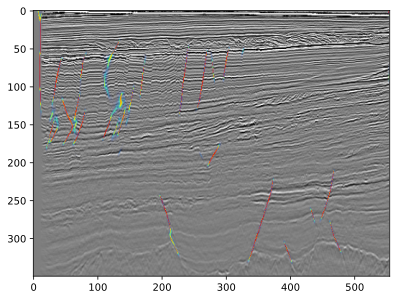

In [9]:
index = (slice(None), 1500, slice(None,350))
plt.imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
plt.imshow(y1[index].T, cmap=cmap2, aspect='auto')
plt.show()

## Multiple Angles Infering

In [10]:
y2 = f3d_p(x, 3, 'multi_angle')

--- Multi Angle Infering ---
1. Normal Infering


2. Infering after rotating 90
3. Infering after rotating 180
4. Infering after rotating 270
5. Merge


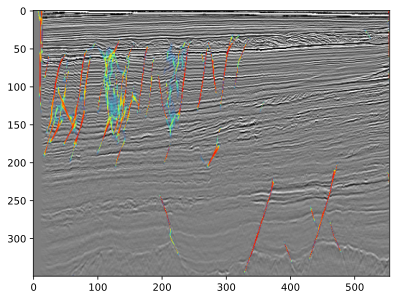

In [11]:
index = (slice(None), 1500, slice(None,350))
plt.imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
plt.imshow(y2[index].T, cmap=cmap2, aspect='auto')
plt.show()

## Multiple resolutions Infering

In [12]:
y3 = f3d_p(x, 3, 'multi_resolution')

--- Multi Resolution Infering ---
1. Normal Infering
2. Infering after reducing resolution of dimension iline
3. Infering after reducing resolution of dimension xline
4. Infering after reducing resolution of dimension time
5. Merge


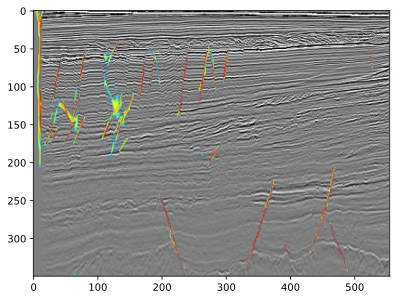

In [13]:
index = (slice(None), 1500, slice(None,350))
plt.imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
plt.imshow(y3[index].T, cmap=cmap2, aspect='auto')
plt.show()

## Multiple Angles and Resolutions Infering

In [14]:
y4 = f3d_p(x, 3, 'multi_angle_resolution')

--- Multi Angle and Resolution Infering ---
--- Multi Angle Infering ---
1. Normal Infering


2. Infering after rotating 90
3. Infering after rotating 180
4. Infering after rotating 270
5. Merge
--- Multi Resolution Infering ---
1. Normal Infering
2. Infering after reducing resolution of dimension iline
3. Infering after reducing resolution of dimension xline
4. Infering after reducing resolution of dimension time
5. Merge
Merge multi angle and resolution


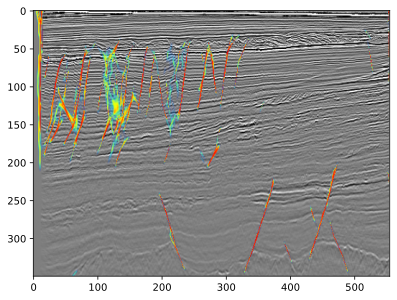

In [15]:
index = (slice(None), 1500, slice(None,350))
plt.imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
plt.imshow(y4[index].T, cmap=cmap2, aspect='auto')
plt.show()

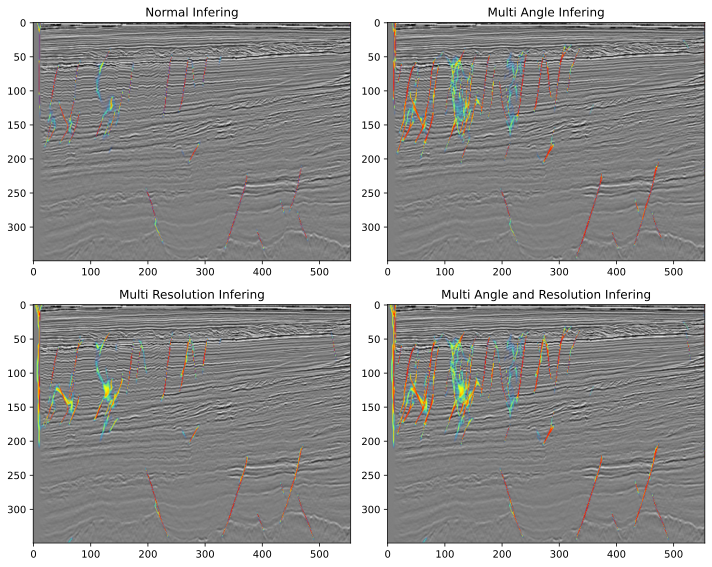

In [16]:
index = (slice(None), 1500, slice(None,350))
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()
ax[0].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[1].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[2].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[3].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[0].imshow(y1[index].T, cmap=cmap2, aspect='auto')
ax[1].imshow(y2[index].T, cmap=cmap2, aspect='auto')
ax[2].imshow(y3[index].T, cmap=cmap2, aspect='auto')
ax[3].imshow(y4[index].T, cmap=cmap2, aspect='auto')
ax[0].set_title('Normal Infering')
ax[1].set_title('Multi Angle Infering')
ax[2].set_title('Multi Resolution Infering')
ax[3].set_title('Multi Angle and Resolution Infering')
plt.tight_layout()
plt.show()

## Infering and Keeping intermediate results

In [17]:
y2, y2_all = f3d_p(x, 3, 'multi_angle', return_all=True)

--- Multi Angle Infering ---
1. Normal Infering


2. Infering after rotating 90
3. Infering after rotating 180
4. Infering after rotating 270
5. Merge


In [18]:
print(y2_all.keys())

dict_keys(['0', '90', '180', '270'])


In [19]:
y3, y3_all = f3d_p(x, 3, 'multi_resolution', return_all=True)

--- Multi Resolution Infering ---
1. Normal Infering
2. Infering after reducing resolution of dimension iline
3. Infering after reducing resolution of dimension xline
4. Infering after reducing resolution of dimension time
5. Merge


In [20]:
print(y3_all.keys())

dict_keys(['normal', 'reduced_i', 'reduced_x', 'reduced_t'])


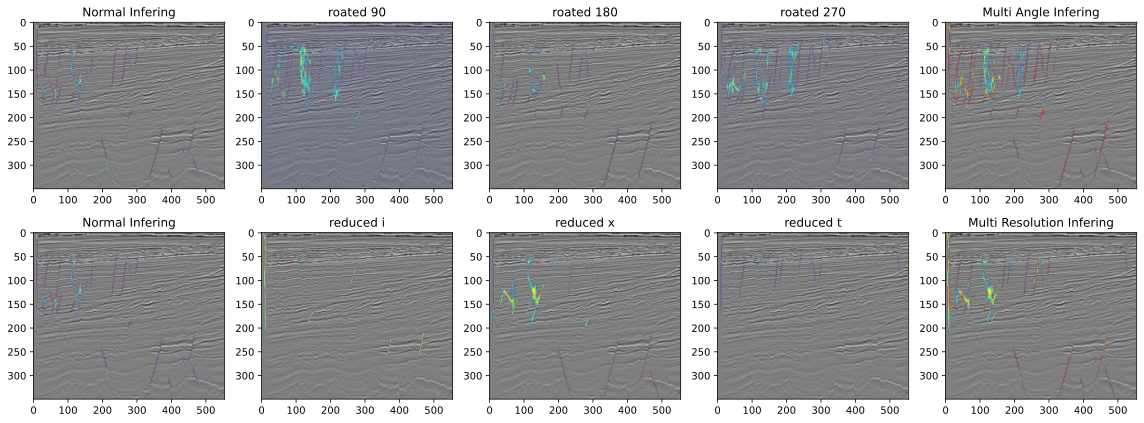

In [21]:
fig, ax = plt.subplots(2, 5, figsize=(16, 6))
ax[0, 0].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[0, 1].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[0, 2].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[0, 3].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[0, 4].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[1, 0].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[1, 1].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[1, 2].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[1, 3].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[1, 4].imshow(x[index].T, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bicubic')
ax[0, 0].imshow(y2_all['0'][index].T, cmap=cmap2, aspect='auto')
ax[0, 1].imshow(y2_all['90'][index].T, cmap=cmap2, aspect='auto')
ax[0, 2].imshow(y2_all['180'][index].T, cmap=cmap2, aspect='auto')
ax[0, 3].imshow(y2_all['270'][index].T, cmap=cmap2, aspect='auto')
ax[0, 4].imshow(y2[index].T, cmap=cmap2, aspect='auto')
ax[1, 0].imshow(y3_all['normal'][index].T, cmap=cmap2, aspect='auto')
ax[1, 1].imshow(y3_all['reduced_i'][index].T, cmap=cmap2, aspect='auto')
ax[1, 2].imshow(y3_all['reduced_x'][index].T, cmap=cmap2, aspect='auto')
ax[1, 3].imshow(y3_all['reduced_t'][index].T, cmap=cmap2, aspect='auto')
ax[1, 4].imshow(y3[index].T, cmap=cmap2, aspect='auto')
ax[0, 0].set_title('Normal Infering')
ax[0, 1].set_title('roated 90')
ax[0, 2].set_title('roated 180')
ax[0, 3].set_title('roated 270')
ax[0, 4].set_title('Multi Angle Infering')
ax[1, 0].set_title('Normal Infering')
ax[1, 1].set_title('reduced i')
ax[1, 2].set_title('reduced x')
ax[1, 3].set_title('reduced t')
ax[1, 4].set_title('Multi Resolution Infering')
plt.tight_layout()
plt.show()